# Práctica 1 - Red Neuronal

## Utilidades

### Configuración del dispositivo de cómputo
Selecciona automáticamente GPU si está disponible, o CPU en caso contrario, e imprime el dispositivo usado para entrenar la red.

In [1]:
import torch

def device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Fijación de semilla para reproducibilidad
La siguiente función, `seed_everything`, asegura que los experimentos sean reproducibles fijando la semilla para PyTorch, CUDA, NumPy y el generador de números aleatorios de Python. También configura CUDA para un comportamiento determinista cuando se usa GPU.

In [2]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Función para mostrar algunas imágenes del dataset

In [3]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import os
def show_images(dataset_path, n=8):
    dataset = ImageFolder(root=os.path.join(dataset_path, 'train'), transform=ToTensor())
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    imgs, labels = next(iter(loader))
    grid = make_grid(imgs[:n], nrow=4) 
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Ejemplos del dataset")
    plt.show()

### Preparación de datasets y dataloaders con Data Augmentation

**`get_train_transforms()`**  
Define y construye el conjunto de **transformaciones aplicadas durante el entrenamiento**.  
Incluye:
- Redimensionamiento y recorte: `Resize` seguido de `RandomResizedCrop` para variabilidad de escala y encuadre.
- Técnicas de *data augmentation* (recorte aleatorio, rotación, volteo horizontal, etc.).
- Conversión a tensor y normalización de los canales (usando medias/desviaciones de `ImageNet` si tl=True, o estándar 0.5 si es `False`).

Estas transformaciones aumentan la variabilidad de los datos, reducen el sobreajuste y mejoran la capacidad de generalización del modelo.

---

**`get_eval_transforms()`**  
Define las transformaciones aplicadas en **validación y test**.  
En este caso **no se utiliza data augmentation**, solo:
- Redimensionamiento al tamaño objetivo.
- Conversión a tensor y normalización idéntica a la del entrenamiento.

El objetivo es mantener las imágenes de evaluación consistentes y medir el rendimiento del modelo sin alteraciones aleatorias.

---

**`prepare_dataloaders_data()`**  
Función principal encargada de:
1. Aplicar las transformaciones correspondientes según el tipo de conjunto (entrenamiento o evaluación) y configurar la normalización.  
2. Cargar las imágenes desde las carpetas `train/`, `val/` y `test`.  
3. Crear los **DataLoader** de PyTorch para cada conjunto:  
   - `train_loader` (con *shuffle*)  
   - `val_loader`  
   - `test_loader`  
4. Devolver la lista de clases del dataset.

Esta función proporciona un pipeline modular y limpio para preparar los datos, compatible con cualquier modelo.


In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# TRANSFORMACIONES DE ENTRENAMIENTO
def get_train_transforms(img_size, tl=False):
    transform_list = []

    # Normalización
    if tl:
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
    else:
        mean = [0.5, 0.5, 0.5]
        std  = [0.5, 0.5, 0.5]

    transform_list += [
        transforms.Resize((int(img_size[0]*1.1), int(img_size[1]*1.1))),  # resize ligeramente mayor
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]

    return transforms.Compose(transform_list)


# TRANSFORMACIONES DE VALIDACIÓN/TEST (sin augmentation)
def get_eval_transforms(img_size, tl=False):
    if tl:
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225]
    else:
        mean = [0.5, 0.5, 0.5]
        std  = [0.5, 0.5, 0.5]

    transform_list = [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]

    return transforms.Compose(transform_list)

# FUNCIÓN PRINCIPAL: DATALOADERS
def prepare_dataloaders_data(
        dataset_path,
        batch_size,
        img_size,
        tl=False,
        num_workers=2):

    train_transform = get_train_transforms(img_size, tl)
    eval_transform  = get_eval_transforms(img_size, tl)

    train_dir = os.path.join(dataset_path, 'train')
    val_dir   = os.path.join(dataset_path, 'val')
    test_dir  = os.path.join(dataset_path, 'test')

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    val_dataset   = datasets.ImageFolder(root=val_dir, transform=eval_transform)
    test_dataset  = datasets.ImageFolder(root=test_dir, transform=eval_transform)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print("\n✅ Datasets cargados correctamente.")

    print(f"Train: {len(train_dataset)} imágenes")
    print(f"Val:   {len(val_dataset)} imágenes")
    print(f"Test:  {len(test_dataset)} imágenes")
    print(f"Clases detectadas ({len(train_dataset.classes)}): {train_dataset.classes}")

    return train_loader, val_loader, test_loader, train_dataset.classes


## Funciones comunes para entreno y validación de modelos

### Entrenar modelo

#### Entreno de una época

`train_one_epoch`: Entrena el modelo durante una época completa.

**Pasos principales:**
- `model.train()`: activa el modo entrenamiento (Dropout, BatchNorm).
- Itera sobre el `DataLoader` para obtener lotes de imágenes y etiquetas.
- Mueve los datos al dispositivo (`CPU/GPU`).
- Realiza el **forward** (`outputs = model(images)`).
- Calcula la **pérdida** con la función `criterion`.
- Hace **backpropagation** (`loss.backward()`).
- Actualiza los pesos con `optimizer.step()`.
- Acumula pérdida y aciertos para calcular:
  - **epoch_loss**: pérdida media de la época.
  - **epoch_acc**: accuracy de la época.

**Salida**:  `(epoch_loss, epoch_acc)`

`validate`: Evalúa el modelo en el conjunto de validación sin actualizar pesos. 

**Pasos principales:**
- `model.eval()`: modo evaluación (Dropout desactivado).
- `with torch.no_grad()`: no calcula gradientes para ahorrar memoria/tiempo.
- Itera sobre el `DataLoader`.
- Calcula:
  - **Loss total** del conjunto.
  - **Accuracy** basado en predicciones correctas.

**Salida**:  `(val_loss, val_acc)`  

In [5]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / total, correct / total

#### EarlyStopping
La clase `EarlyStopping` sirve para **detener el entrenamiento de un modelo automáticamente** si la métrica de interés (por ejemplo, accuracy de validación) deja de mejorar durante varias épocas consecutivas.

In [6]:
class EarlyStopping:
    def __init__(self, patience=8, mode='max', verbose=False):
        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        score = current_score if self.mode == 'max' else -current_score

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_weights(self, model):
        if self.best_model_state:
            model.load_state_dict(self.best_model_state)

#### Entrenamiento completo

Esta función realiza un **entrenamiento completo del modelo** con validación y early stopping.

**Pasos principales:**

1. **Definir criterio y optimizador**  
   - `criterion = CrossEntropyLoss()` → calcula la pérdida de clasificación.  
   - `optimizer = Adam` → actualiza los pesos del modelo.

2. **EarlyStopping**  
   - Monitorea la métrica de validación (`val_acc`).  
   - Detiene el entrenamiento si no mejora durante `patience` épocas.  
   - Guarda los mejores pesos automáticamente.

3. **Entrenamiento por épocas**  
   Para cada época:
   - `train_one_epoch`: realiza entrenamiento completo de la época.
   - `validate`: evalúa el modelo en el conjunto de validación.
   - Se registran las métricas (`loss` y `accuracy`) en el historial.
   - Se imprime el progreso de la época.

4. **Chequeo de EarlyStopping**  
   - Si la métrica de validación no mejora, se detiene el entrenamiento antes de llegar al número máximo de épocas.

5. **Cargar los mejores pesos**  
   - Después de terminar, `es.load_best_weights(model)` restaura los pesos del modelo con mejor rendimiento en validación.

**Salida:**  
- `history`: diccionario con listas de pérdidas y accuracies para entrenamiento y validación.

In [7]:
import torch.optim as optim
import torch.nn as nn

def train_experiment(model, train_loader, val_loader, epochs, lr, patience, device, weight_decay):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    es = EarlyStopping(patience=patience, mode='max', verbose=True)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(1, epochs+1):
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = validate(model, val_loader, criterion, device)
        
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)
        
        print(f"Epoch {epoch}/{epochs} - Train loss: {t_loss:.4f} acc: {t_acc:.4f} | Val loss: {v_loss:.4f} acc: {v_acc:.4f}")
        
        es(v_acc, model)
        if es.early_stop:
            print("Early stopping triggered")
            break
            
    es.load_best_weights(model)
    return history

### Evaluar modelo

Esta función **evalúa el rendimiento del modelo** en un conjunto de datos (por ejemplo, test o validación) y devuelve métricas detalladas.

**Pasos principales:**
- `model.eval()`: modo evaluación (Dropout desactivado).
- `with torch.no_grad()`: no calcula gradientes para ahorrar memoria/tiempo.
- Función de pérdida: `CrossEntropyLoss()
- Itera sobre el `DataLoader`.
    Para cada lote:
    - Mueve imágenes y etiquetas al dispositivo (CPU/GPU)
    - Calcula las predicciones (outputs = model(images)).
    - Calcula la pérdida (loss = criterion(outputs, labels)).
    - Guarda predicciones y etiquetas reales.
- Calcula métricas finales:
  - **Loss total**, pérdida promedio del conjunto.
  - **Accuracy** basado en predicciones correctas

**Salida**: 
- **acc**: accuracy total en porcentaje.
- **avg_loss**: pérdida promedio.
- **all_labels**: array con todas las etiquetas verdaderas.
- **all_preds**: array con todas las predicciones del modelo.

In [8]:
def evaluate_model(model, loader, device):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    total = len(all_labels)
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / total * 100
    avg_loss = running_loss / total
    
    return acc, avg_loss, np.array(all_labels), np.array(all_preds)

## Análisis de métricas

### Gráfico de las curvas de accuracy durante el entrenamiento y la validación de la red neuronal.
A continuación, se definirá una función que muestre cómo cambian la pérdida (loss) y la precisión (accuracy) del modelo en entrenamiento y validación a lo largo de las épocas. Esto permite evaluar el aprendizaje de la red, detectar overfitting o underfitting, y comparar el desempeño entre diferentes configuraciones del modelo.

La precisión se calcula como:
$$
\text{Accuracy} = \frac{\text{Número de predicciones correctas}}{\text{Número total de predicciones}} \times 100\%
$$

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy - {title}')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Matriz de confusión
Asimismo, la siguiente función muestra la comparación entre las etiquetas reales (`y_true`) y las predicciones del modelo (`y_pred`) para cada clase. Permite identificar qué clases se confunden entre sí y evaluar detalladamente el desempeño del modelo en clasificación.

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title="Confusion Matrix"):
    if y_true is None or y_pred is None: return
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('Etiqueta Real'); plt.xlabel('Etiqueta Predicha')
    plt.tight_layout(); plt.show()

### Guardar campos en el CSV

In [11]:
import json
import pandas as pd
import os

def save_results(all_results, dataset_name="dataset"):
    """
    Guarda resultados en un CSV cuyo nombre se pasa como parámetro
    """

    if not all_results:
        return

    csv_filename = f"resultados_{dataset_name}.csv"

    # Convertir resultados a DataFrame columna única
    df_results = pd.DataFrame(all_results)
    df_results["history_dict"] = df_results["history_dict"].apply(json.dumps)
    df_results["y_true"] = df_results["y_true"].apply(lambda x: json.dumps(x.tolist()))
    df_results["y_pred"] = df_results["y_pred"].apply(lambda x: json.dumps(x.tolist()))

    df_csv = df_results.T

    # Función para reemplazar puntos por comas
    def decimal_to_comma(df):
        return df.applymap(lambda x: str(x).replace('.', ',') if isinstance(x, (float, int)) else x)

    # Si el archivo no existe → se crea
    if not os.path.exists(csv_filename):
        df_to_save = decimal_to_comma(df_csv)
        df_to_save.to_csv(csv_filename, sep=';', index=True)

    # Si ya existe → se agrega una columna nueva
    else:
        df_prev = pd.read_csv(csv_filename, sep=';', index_col=0)
        df_new = decimal_to_comma(df_csv)

        # Alinear e insertar
        df_prev, df_new = df_prev.align(df_new, join='outer')
        df_combined = pd.concat([df_prev, df_new], axis=1)

        df_combined.to_csv(csv_filename, sep=';', index=True)

    print(f"✔ Resultados guardados en: {csv_filename}\n")


### Analizar mejor y peor experimento desde CSV

In [12]:
import ast

def robust_json_load(x):
    """
    Intenta cargar JSON de forma estricta. Si falla, intenta corregir
    formatos comunes (comillas simples, booleanos de Python, etc.)
    usando ast.literal_eval.
    """
    if not isinstance(x, str):
        return x
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        try:
            return ast.literal_eval(x.replace("null", "None").replace("true", "True").replace("false", "False"))
        except Exception as e:
            print(f"Error decodificando: {e}")
            return None

def analyze_from_csv(csv_filename, classes):
    df = pd.read_csv(csv_filename, sep=';', index_col=0).T
    json_cols = ["history_dict", "y_true", "y_pred"]
    
    for col in json_cols:
        if col in df.columns: df[col] = df[col].apply(robust_json_load)
    if "test_acc" in df.columns:
        df["test_acc"] = df["test_acc"].astype(str).str.replace(',', '.').astype(float)

    best = df.loc[df["test_acc"].idxmax()]
    worst = df.loc[df["test_acc"].idxmin()]

    print(f"🏆 Mejor: {best['name']} - {best['test_acc']}%")
    print(f"📉 Peor: {worst['name']} - {worst['test_acc']}%")

    plot_training_history(best["history_dict"], f"({best['name']})")
    plot_confusion_matrix(best["y_true"], best["y_pred"], classes, f"Confusion ({best['name']})")

    plot_training_history(worst["history_dict"], f"({worst['name']})")
    plot_confusion_matrix(worst["y_true"], worst["y_pred"], classes, f"Confusion ({worst['name']})")

## Entrenamiento CNN desde cero

### Modelo

Este bloque define un **modelo CNN completamente modular y configurable**. Permite ajustar el número de capas convolucionales, filtros, kernel sizes, repeticiones, y también la estructura de las capas densas.

- **Bloques convolucionales**: cada bloque aplica varias Conv2D + LeakyReLU para extraer características, seguido de MaxPool para reducir la resolución espacial y Dropout para evitar sobreajuste.

- **Cálculo automático del tamaño plano**: se usa un `dummy_input` para pasar por la parte convolucional y obtener automáticamente el tamaño exacto que debe recibir la primera capa densa.

- **Capas densas (FC)**: construyen un clasificador configurable, con activaciones LeakyReLU y Dropout para regularización.

- **Capa final**: genera la salida final del modelo, lista para usar con `CrossEntropyLoss` (por eso no contiene Softmax).

In [ ]:
# ModularCNN  
import torch
import torch.nn as nn
import numpy as np

class ModularCNN(nn.Module):
    def __init__(
        self,
        input_shape,
        conv_layers,          # lista: [(filtros, kernel, reps)
        fc_layers,            # lista de unidades densas
        num_classes=6,
        dropout_conv=0.3,
        dropout_fc=0.4,
    ):
        super(ModularCNN, self).__init__()

        self.features = nn.Sequential()
        in_channels = input_shape[2]

        # Construir bloques convolucionales según conv_layers
        for i, layer_def in enumerate(conv_layers):
            if len(layer_def) == 3:
                out_channels, k, reps = layer_def
            else:
                raise ValueError("Cada elemento de conv_layers debe ser 3 tuplas")

            for r in range(reps):
                self.features.add_module(
                    f"conv_{i}_{r}",
                    nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=k//2)
                )
                self.features.add_module(f"relu_{i}_{r}", nn.ReLU(inplace=True))
                in_channels = out_channels

            # Pool + dropout por bloque
            self.features.add_module(f"pool_{i}", nn.MaxPool2d(2, 2))
            if dropout_conv and dropout_conv > 0:
                self.features.add_module(f"drop_{i}", nn.Dropout2d(dropout_conv))

        # Calcular flat dim robustamente
        with torch.no_grad():
            dummy = torch.zeros(1, input_shape[2], input_shape[0], input_shape[1])
            tmp = self.features(dummy)
            self.flat_dim = int(np.prod(tmp.size()))

        # Clasificador fully-connected
        self.classifier = nn.Sequential()
        in_features = self.flat_dim
        for j, units in enumerate(fc_layers):
            self.classifier.add_module(f"fc_{j}", nn.Linear(in_features, units))
            self.classifier.add_module(f"relu_fc_{j}", nn.ReLU(inplace=True))
            if dropout_fc and dropout_fc > 0:
                self.classifier.add_module(f"drop_fc_{j}", nn.Dropout(dropout_fc))
            in_features = units

        # Capa salida
        self.classifier.add_module("fc_out", nn.Linear(in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


### Entrenamientos 

In [ ]:
import torch

def main():
    # --- Configuración global para INTEL DATASET ---
    BATCH_SIZE = 64        
    INPUT_CHANNELS = 3     
    EPOCHS = 80
    SEED=42
    DEVICE = device()
    IMG_SIZE = (150, 150)  
    WEIGHT_DECAY = 1e-4   

    # DEFINICIÓN DE EXPERIMENTOS
    EXPERIMENTS = [
    {
        "name": "Experimento 1",
        "conv_layers": [
            (32, 3, 1), 
            (64, 3, 1), 
            (128, 3, 2), 
            (256, 3, 1) 
        ],
        "fc_layers": [512, 128], 
        "lr": 1e-3,
        "dropout_conv": 0.2,
        "dropout_fc": 0.4
    },
    {
        "name": "Experimento 2",
        "conv_layers": [
            (32, 3, 2), 
            (64, 3, 2), 
            (128, 3, 2)
        ],
        "fc_layers": [256],
        "lr": 5e-4, 
        "dropout_conv": 0.3,
        "dropout_fc": 0.5
    },
    {
        "name": "Experimento 3",
        "conv_layers": [
            (64, 3, 1),
            (128, 3, 1),
            (256, 3, 2),
            (512, 3, 1)
        ],
        "fc_layers": [512, 256],
        "lr": 8e-4,
        "dropout_conv": 0.25,
        "dropout_fc": 0.4
    },
    {
        "name": "Experimento 4",
        "conv_layers": [
            (32, 3, 1),
            (32, 3, 1),
            (64, 3, 2),
            (64, 3, 1),
            (128, 3, 2),
            (128, 3, 1)
        ],
        "fc_layers": [256, 64],
        "lr": 7e-4,
        "dropout_conv": 0.3,
        "dropout_fc": 0.5
    },
    {
        "name": "Experimento 5",
        "conv_layers": [
            (32, 5, 1),
            (64, 5, 2),
            (128, 5, 1)
        ],
        "fc_layers": [512],
        "lr": 5e-4,
        "dropout_conv": 0.2,
        "dropout_fc": 0.4
    },
    {
        "name": "Experimento 6",
        "conv_layers": [
            (32, 3, 1),
            (32, 3, 2),
            (64, 3, 1),
            (64, 3, 2),
            (128, 3, 1)
        ],
        "fc_layers": [128],
        "lr": 1e-3,
        "dropout_conv": 0.15,
        "dropout_fc": 0.3
    },
    {
        "name": "Experimento 7",
        "conv_layers": [
            (32, 3, 1),
            (64, 3, 2),
            (128, 3, 1)
        ],
        "fc_layers": [256, 128],
        "lr": 1e-3,
        "dropout_conv": 0.5,
        "dropout_fc": 0.6
    },
    {
        "name": "Experimento 8",
        "conv_layers": [
            (32, 3, 1),
            (64, 3, 1),
            (128, 3, 2)
        ],
        "fc_layers": [256],
        "lr": 1e-4,     
        "dropout_conv": 0.2,
        "dropout_fc": 0.4
    },
    ]

    # 1. SETUP & DATOS 
    seed_everything(SEED)

    print("Descargando dataset Intel Image Classification...")
    current_dir = os.getcwd()
    dataset_path = os.path.join(current_dir, "Dataset")

    show_images(dataset_path)
    
    # Preparar datos con data augmentation
    train_loader, val_loader, test_loader, classes = prepare_dataloaders_data(
        dataset_path=dataset_path,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        tl=False
    )
    
    all_results = []
    # Ajustamos input shape a 3 canales
    input_shape = (IMG_SIZE[0], IMG_SIZE[1], INPUT_CHANNELS)
    
    # 2. EJECUCIÓN DE EXPERIMENTOS
    for exp in EXPERIMENTS:
        print(f"\n🚀 Entrenando: {exp['name']}")
        
        # A. CONSTRUIR
        model = ModularCNN(
            input_shape=input_shape,
            conv_layers=exp["conv_layers"],
            fc_layers=exp["fc_layers"],
            num_classes=len(classes),
            dropout_conv=exp.get("dropout_conv", 0.3),
            dropout_fc=exp.get("dropout_fc", 0.4)
        ).to(DEVICE)

        # B. ENTRENAR
        history = train_experiment(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            lr=exp["lr"],
            patience=10, 
            device=DEVICE,
            weight_decay=WEIGHT_DECAY
        )

        # D. EVALUAR
        test_acc, test_loss, y_true, y_pred = evaluate_model(model, test_loader, device=DEVICE)
        print(f"[{exp['name']}] Test Accuracy = {test_acc:.4f}%")

        # GUARDAR MODELOS
        os.makedirs("models", exist_ok=True)
        model_path = f"models/{exp['name'].replace(' ', '_')}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Modelo guardado en: {model_path}")

        # E. ALMACENAR RESULTADOS
        result_entry = {
            "name": exp['name'],
            "conv_layers_config": str(exp["conv_layers"]),
            "fc_layers_config": str(exp["fc_layers"]),
            "learning_rate": exp["lr"],
            "dropout_conv": exp.get("dropout_conv", 0.3),
            "dropout_fc": exp.get("dropout_fc", 0.4),
            "epochs_run": len(history["train_loss"]),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "history_dict": history,
            "y_true": y_true,
            "y_pred": y_pred
        }
        all_results.append(result_entry)

    # 3. GUARDAR
    save_results(all_results, dataset_name="intel_paisajes")
        
if __name__ == "__main__":
    main()

### Análisis de los experimentos


✅ Datasets cargados correctamente.
Train: 11230 imágenes
Val:   2804 imágenes
Test:  3000 imágenes
Clases detectadas (6): ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Iniciando análisis ...
🏆 Mejor: Experimento 5 - 87.2%
📉 Peor: Experimento 7 - 80.06666666666666%


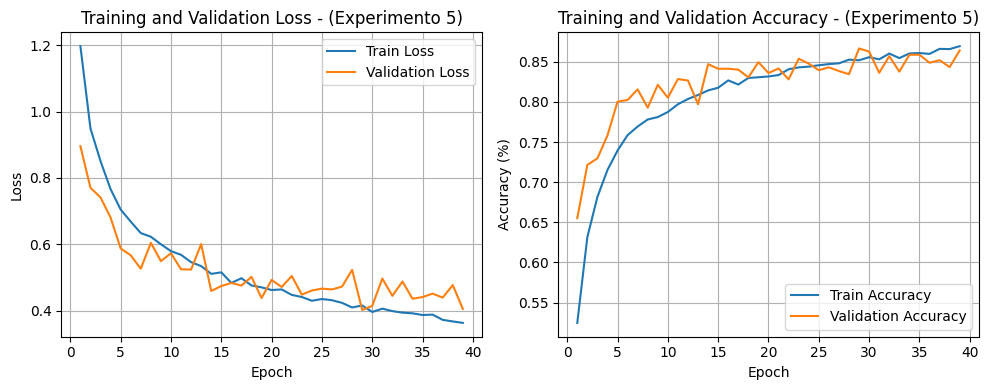

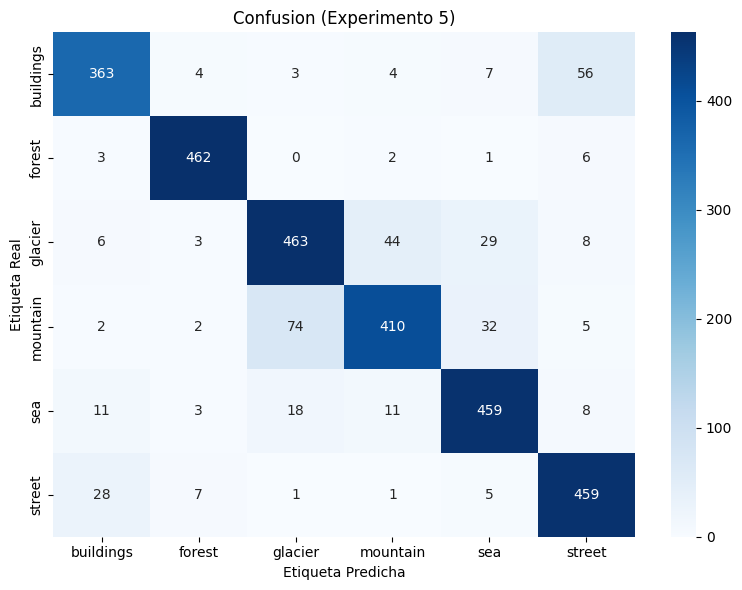

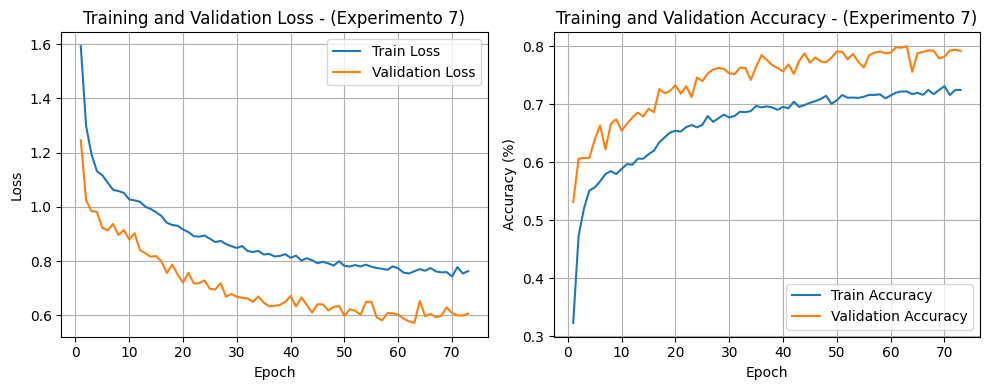

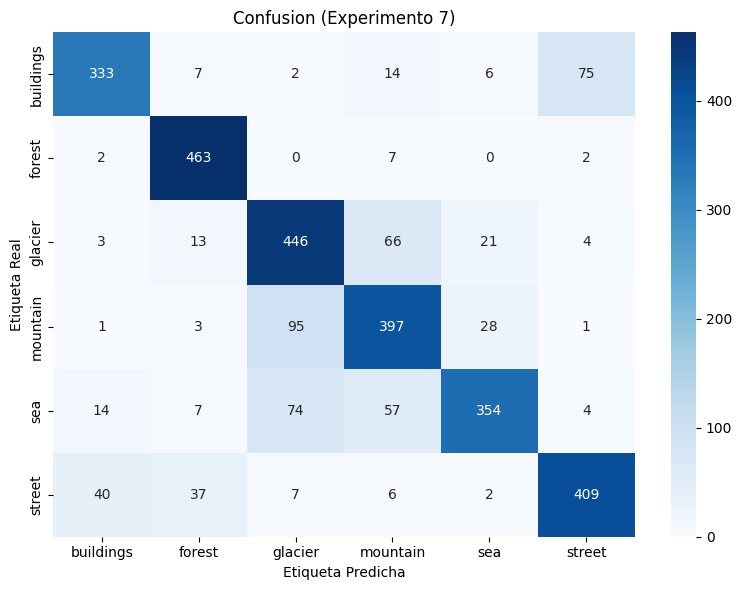

✅ Análisis completado.


In [15]:
import os
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, "Dataset")
BATCH_SIZE = 64
IMG_SIZE=(150,150)

train_loader, val_loader, test_loader, classes = prepare_dataloaders_data(
    dataset_path=dataset_path,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    tl=False
)
    

try:
    print("Iniciando análisis ...")
    analyze_from_csv("resultados_intel_paisajes.csv", classes)
    print("✅ Análisis completado.")
except Exception as e:
    print(f"❌ Error durante el análisis: {e}")

## Entrenamiento CNN con Transfer Learning

### Modelo

In [16]:
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

def build_model_transfer_learning(num_classes, device):
    weights = ResNet18_Weights.IMAGENET1K_V1 
    model = models.resnet18(weights=weights)

    # ---  CONGELAR LOS PESOS ---
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)

### Entrenamientos

In [ ]:
def main():

    # --- Configuración global ---
    BATCH_SIZE = 32
    EPOCHS = 50
    SEED = 42
    DEVICE = device()
    IMG_SIZE = (224, 224)
    WEIGHT_DECAY = 1e-4

    EXPERIMENTOS = [
        {
            "name": "Experimento 1 - TL",
            "lr": 1e-4,      
        },
        {
            "name": "Experimento 2 - TL", 
            "lr": 3e-4,
        },
        {
            "name": "Experimento 3 - TL",
            "lr": 1e-3,      
        },
        {
            "name": "Experimento 4 - TL",
            "lr": 5e-5,
        }
    ]

    # 1. SETUP & DATOS
    seed_everything(SEED)

    print("Descargando dataset Intel Image Classification...")
    current_dir = os.getcwd()
    dataset_path = os.path.join(current_dir, "Dataset")

    show_images(dataset_path)


    # Preparar datos con data augmentation
    train_loader, val_loader, test_loader, classes = prepare_dataloaders_data(
        dataset_path=dataset_path,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        tl=True
    )
    all_results = []

    # 2. EJECUCIÓN DE EXPERIMENTOS
    for exp in EXPERIMENTOS:
        print("\n====================================")
        print(f"Entrenando experimento: {exp['name']}")
        print("====================================\n")

        # A. CONSTRUIR MODELO
        model = build_model_transfer_learning(len(classes), DEVICE)

        # B. ENTRENAR
        history = train_experiment(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS,
            lr=exp["lr"],
            patience=10,
            device=DEVICE,
            weight_decay=WEIGHT_DECAY
        )

        # D. EVALUAR
        test_acc, test_loss, y_true, y_pred = evaluate_model(model, test_loader, device=DEVICE)
        print(f"[{exp['name']}] Test Accuracy = {test_acc:.4f}%")

        # GUARDAR MODELOS
        os.makedirs("models", exist_ok=True)
        model_path = f"models/{exp['name'].replace(' ', '_')}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Modelo guardado en: {model_path}")

        # E. ALMACENAR RESULTADOS
        result_entry = {
            "name": exp['name'],
            "epochs_run": len(history["train_loss"]),
            "learning_rate": exp["lr"],
            "test_loss": test_loss,
            "test_acc": test_acc,
            "history_dict": history,
            "y_true": y_true, 
            "y_pred": y_pred
        }
        
        all_results.append(result_entry)

    # 3. GUARDAR EN CSV
    save_results(all_results, dataset_name="cnn_transfer")

if __name__ == "__main__":
    main()

### Análisis experimentos


✅ Datasets cargados correctamente.
Train: 11230 imágenes
Val:   2804 imágenes
Test:  3000 imágenes
Clases detectadas (6): ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Iniciando análisis...
🏆 Mejor: Experimento 1 - TL - 90.10000000000001%
📉 Peor: Experimento 4 - TL - 89.96666666666667%


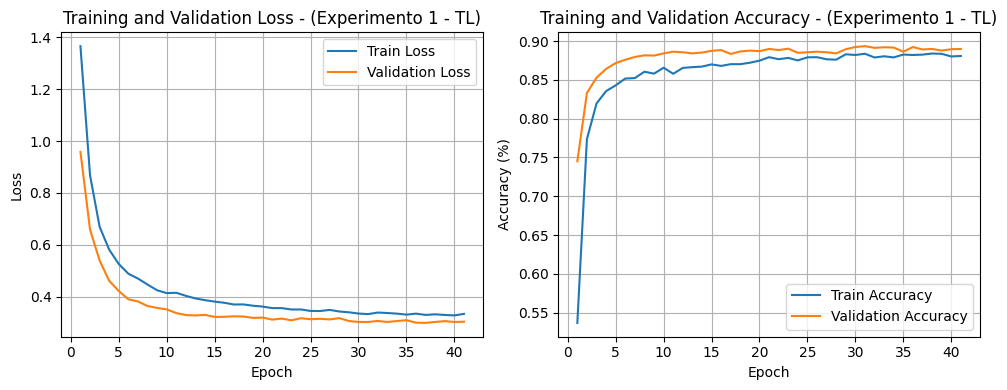

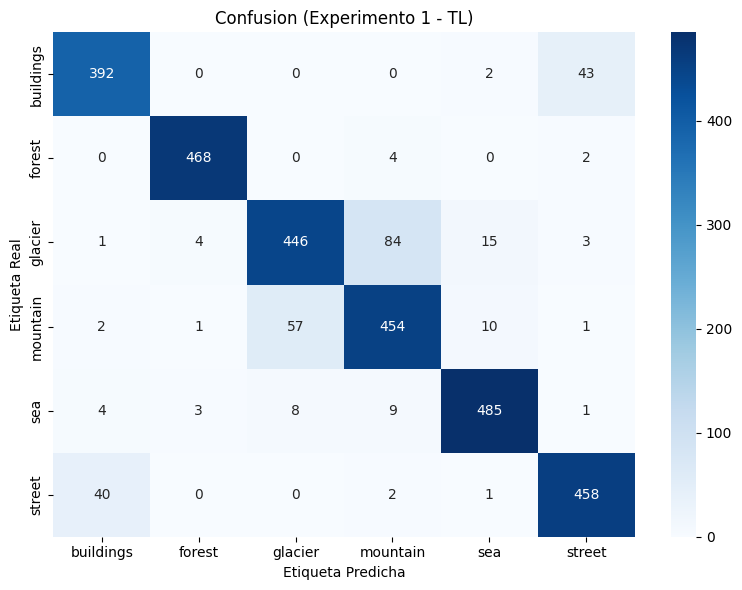

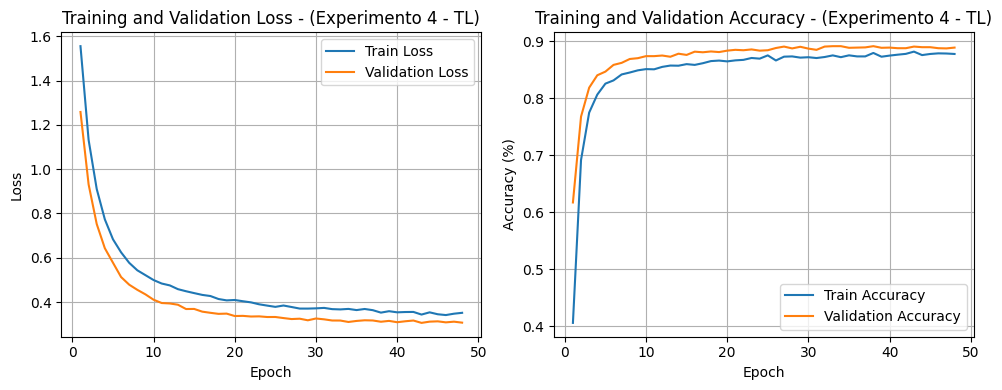

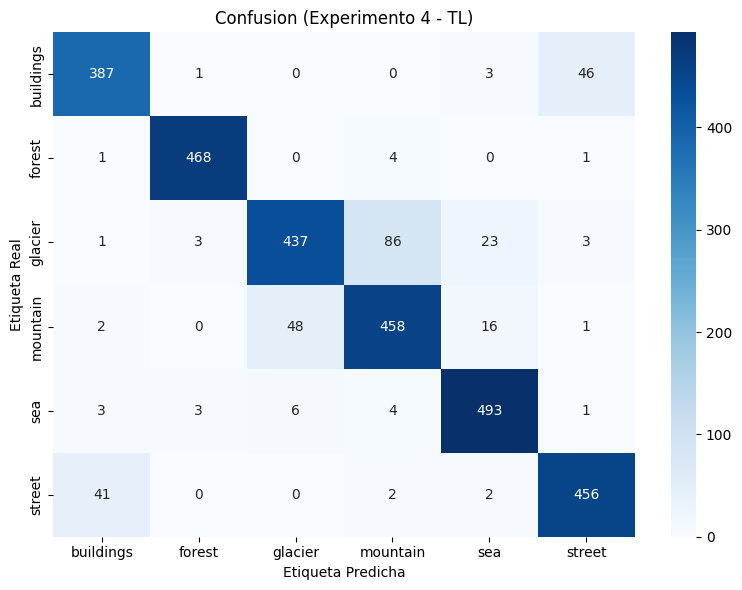

✅ Análisis completado.


In [17]:
import os
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, "Dataset")
BATCH_SIZE = 64
IMG_SIZE=(150,150)

train_loader, val_loader, test_loader, classes = prepare_dataloaders_data(
    dataset_path=dataset_path,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    tl=False
)    

try:
    print("Iniciando análisis...")
    analyze_from_csv("resultados_cnn_transfer.csv", classes)
    print("✅ Análisis completado.")
except Exception as e:
    print(f"❌ Error durante el análisis: {e}")